<a href="https://colab.research.google.com/github/jdmedinatobon/tesis/blob/master/PruebaColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalación

In [1]:
#Correr esta celda si se utiliza Google Colab con un ambiente remoto.
!pip install progressbar2
!pip install gym

# Librerías

In [0]:
import time
import numpy as np
import copy

import progressbar
import gym

%tensorflow_version 1.x
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.initializers import RandomNormal

%matplotlib inline
import matplotlib.pyplot as plt

#Clase

In [0]:
class ExperienceReplay():
    def __init__(self, tamano_minimo = 1000, tamano_maximo = 10**6, tamano_batch = 32):
        self.tamano_buffer = 0
        self.tamano_batch = tamano_batch
        self.tamano_minimo = tamano_minimo
        self.tamano_maximo = tamano_maximo
        self.buffer = np.empty(1)
        
    def agregarDato(self, x, a, r, xp):
        dato = dict({'St':x, 'At':a, 'Rt+1':r, 'St+1':xp})
        
        if(self.tamano_buffer == 0):
            self.buffer = np.append(self.buffer, dato)
            self.buffer = np.delete(self.buffer, 0)
            self.tamano_buffer = 1
        else:
            self.buffer = np.append(self.buffer, dato)
            self.tamano_buffer += 1
        
        if(self.tamano_buffer > self.tamano_maximo):
            self.buffer = np.delete(self.buffer, 0)
            self.tamano_buffer -= 1
            
    
    def darMuestras(self):
        indices = np.random.choice(range(self.tamano_buffer), size = self.tamano_batch, replace = False)
        return self.buffer[indices]

#Table Lookup

Pendulum-v0<br /> 
Utilizando el algoritmo de Sarsa.<br />
Está como chambón pero funciona.

In [0]:
def darIndice(pS):
    return int(round(pS, 1)*10+10)

def escogerAccion(pS1, pS2, pS3):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0,41)
        return ind
    else:
        ind = np.where(tablaQ[pS1, pS2, pS3, :] == np.amax(tablaQ[pS1, pS2, pS3, :]))
        ind = ind[0]
        
        if(len(ind) > 1):
            return np.random.choice(ind)
        else:
            return ind
    
    return accion

In [0]:
envName = 'Pendulum-v0'

g = 0.9
alpha = 0.5
epsilon = 0.1 #Entre 0 y 1
maxIter = 1500000
ventana = 100
epsilonIterLimit = maxIter*0.9

tablaQ = np.ones((21,21,17,41))*-16
rewards = np.zeros(int(maxIter/10))

env = gym.make(envName)
observation = env.reset()

s1 = darIndice(observation[0])
s2 = darIndice(observation[1])
s3 = int(round(observation[2], 0) + 8)
a = escogerAccion(s1, s2, s3)

suma = 0

for i in progressbar.progressbar(range(maxIter)):
    
    if(i > maxIter-2000):
        env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
    if(i > epsilonIterLimit):
        epsilon = 0
    
env.close()

In [0]:
for i in progressbar.progressbar(range(2000)):
    env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
env.close()

#DQN

In [0]:
#Creando redes neuronales
def crearRedes(n1 = 20, n2 = 41, learning_rate = 0.01):
    init = RandomNormal(seed = 0)
    
    modelo = Sequential()
    
    modelo.add(Dense(n1, activation = 'relu', kernel_initializer = init, bias_initializer = init, input_dim = 3))
    modelo.add(Dense(n2, activation = 'linear', kernel_initializer = init, bias_initializer = init))
    
    sgd = optimizers.sgd(lr = learning_rate)
    
    modelo.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])
    
    return modelo, copy.deepcopy(modelo)

def actualizarRedTarget(pRedPrincipal, pRedTarget):
    
    for i in range(len(pRedPrincipal.layers)):
        pesosPrincipal = pRedPrincipal.layers[i].get_weights()
        pesosTarget = pRedTarget.layers[i].get_weights()
        
        pesos = [tao*l1 + (1-tao)*l2 for l1, l2 in zip(pesosPrincipal, pesosTarget)]
        
        pRedTarget.layers[i].set_weights(pesos)

def escogerAccion(pModelo, pX):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0,41)
        return ind
    else:
        ind = np.argmax(pModelo.predict(pX))
        return ind

In [6]:
envName = 'Pendulum-v0'

modeloPrincipal, modeloTarget = crearRedes(learning_rate = 0.01)

#Con los parametros default.
buffer = ExperienceReplay()

gamma = 0.99
alpha = 0.35
epsilon = 1#Entre 0 y 1
epsilonDecay = 0.99
tao = 0.001

episodes = 100
stepsPrueba = 500
maxSteps = 100
contadores = np.zeros((1,41))

rewardsAcumulados = np.zeros(episodes)

env = gym.make(envName)
observation = env.reset()

x = np.reshape(observation, (1,3))
x[0,2] = x[0,2]/8.0

a = escogerAccion(modeloPrincipal, x)

#Este es un for inicial donde se almacena la cantidad minima de datos requerida en el buffer
#antes de comenzar con el entrenamiento.
for i in progressbar.progressbar(range(buffer.tamano_minimo)):
    observation, reward, done, info = env.step([(a-20.0)/10.0])
    
    xp = np.reshape(observation, (1,3))
    xp[0,2] = xp[0,2]/8.0
    x = xp
    
    buffer.agregarDato(x, a, reward, xp)
    
    #epsilon es 1 asi que siempre va a escoger al azar.
    a = escogerAccion(modeloPrincipal, x)
    
for e in progressbar.progressbar(range(episodes)):
    rewardAcumulado = 0
    observation = env.reset()
    x = np.reshape(observation, (1,3))
    x[0,2] = x[0,2]/8.0
    a = escogerAccion(modeloPrincipal, x)
    
    for s in range(maxSteps):
        observation, reward, done, info = env.step([(a-20.0)/10.0])
        
        rewardAcumulado += reward
        
        xp = observation
        xp = np.reshape(xp, (1,3))
        xp[0,2] = xp[0,2]/8.0

        buffer.agregarDato(x, a, reward, xp)

        muestras = buffer.darMuestras()

        #Pasar esto a un metodo solito
        xEnt = np.empty((1,3))
        aEnt = np.empty(1)
        rEnt = np.empty(1)
        xpEnt = np.empty((1,3))

        for m in muestras:
            xEnt = np.append(xEnt, m.get('St'), axis = 0)
            aEnt = np.append(aEnt, [m.get('At')], axis = 0)
            rEnt = np.append(rEnt, [m.get('Rt+1')], axis = 0)
            xpEnt = np.append(xpEnt, m.get('St+1'), axis = 0)

        xEnt = np.delete(xEnt, 0, axis = 0)
        aEnt = np.delete(aEnt, 0, axis = 0)
        rEnt = np.delete(rEnt, 0, axis = 0)
        xpEnt = np.delete(xpEnt, 0, axis = 0)

        qValores = modeloPrincipal.predict(xEnt)

        qValoresTarget = modeloTarget.predict(xEnt)
        maxQvalores = np.amax(qValoresTarget, axis = 1)

        #Aqui hay que calcular el maximo
        targets = np.add(rEnt, gamma*maxQvalores)

        yEnt = qValores

        for j in range(buffer.tamano_batch):
            yEnt[j,int(aEnt[j])] = targets[j]

        modeloPrincipal.train_on_batch(xEnt, yEnt)
        actualizarRedTarget(modeloPrincipal, modeloTarget)

        x = xp
        a = escogerAccion(modeloPrincipal, x)

    epsilon = epsilon*epsilonDecay
    rewardsAcumulados[e] = rewardAcumulado

observation = env.reset()
x = np.reshape(observation, (1,3))
x[0,2] = x[0,2]/8.0
a = escogerAccion(modeloPrincipal, x)    
    
for s in range(stepsPrueba):
    
    observation, reward, done, info = env.step([(a-20.0)/10.0])
    
    env.render()
    
    xp = observation
    xp = np.reshape(xp, (1,3))
    xp[0,2] = xp[0,2]/8.0
    
    a = escogerAccion(modeloPrincipal, xp)
    
env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100% (1000 of 1000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (100 of 100) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


NoSuchDisplayException: ignored

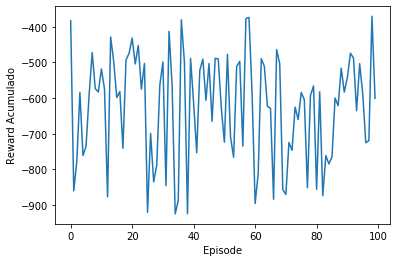

In [7]:
plt.plot(rewardsAcumulados)
plt.xlabel('Episode')
plt.ylabel('Reward Acumulado')
plt.show()